# Загрузка датесета из github

In [41]:
!mkdir hotels-50k
!wget -P hotels-50k https://github.com/GWUvision/Hotels-50K/raw/master/input/dataset.tar.gz
!tar -xvzf hotels-50k/dataset.tar.gz -C hotels-50k
!rm hotels-50k/dataset.tar.gz

mkdir: cannot create directory ‘hotels-50k’: File exists
--2023-09-07 11:30:21--  https://github.com/GWUvision/Hotels-50K/raw/master/input/dataset.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GWUvision/Hotels-50K/master/input/dataset.tar.gz [following]
--2023-09-07 11:30:21--  https://raw.githubusercontent.com/GWUvision/Hotels-50K/master/input/dataset.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14353865 (14M) [application/octet-stream]
Saving to: ‘hotels-50k/dataset.tar.gz’

dataset.tar.gz      100%[===================>]  13.69M  --.-KB/s    in 0.08s   

2023-09-07 11:30

# Загрузка библиотек

In [42]:
!pip install pandas
!pip install plotly
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install torch
!pip install transformers
!pip install requests
!pip install nbformat
!pip install ipywidgets
!pip install scikit-learn


# Загрузка набора данных


In [43]:
import pandas as pd

In [44]:
chain_df = pd.read_csv("./hotels-50k/dataset/chain_info.csv")
display(chain_df.head())

,chain_id,chain_name
0,-1,unknown
1,0,Best Western
2,1,Hyatt
3,2,Marriott
4,3,Hilton


In [45]:
hotel_df = pd.read_csv("./hotels-50k/dataset/hotel_info.csv")
display(hotel_df.head())

,hotel_id,hotel_name,chain_id,latitude,longitude
0,391,Extended Stay America - Fairbanks - Old Airpor...,72,64.83538,-147.82330
1,392,Hilton Hangzhou Qiandao Lake Resort,3,29.60819,119.07290
2,393,Taj Lands End,-1,19.04391,72.81879
3,395,Cambridge Suites Hotel Sydney,-1,46.13663,-60.19551
4,396,Tamanu Beach,14,-18.84213,-159.78794


In [46]:
train_df = pd.read_csv('./hotels-50k/dataset/train_set.csv', header=None,
                       names=['image_id', 'hotel_id', 'url', 'source', 'timestamp'])

display(train_df.head())

,image_id,hotel_id,url,source,timestamp
0,3485,18187,https://traffickcam.com/images/2016/10/2015090...,traffickcam,9/9/15 17:23
1,3486,18187,https://traffickcam.com/images/2016/10/2015090...,traffickcam,9/9/15 17:23
2,3663,73224,https://traffickcam.com/images/2016/10/2015091...,traffickcam,9/17/15 19:33
3,2586939,86350,https://traffickcam.com/images/2017/2/20160125...,traffickcam,1/25/16 19:12
4,2586950,1533,https://traffickcam.com/images/2017/2/20160125...,traffickcam,1/25/16 17:23


# Hotels-50k data

In [47]:
data_df = train_df.merge(hotel_df, on="hotel_id").merge(chain_df, on="chain_id")
data_df["image_id"] = data_df["image_id"].astype(str)
data_df["hotel_id"] = data_df["hotel_id"].astype(str)
data_df["chain_id"] = data_df["chain_id"].astype(str)

display(data_df.head())

,image_id,hotel_id,url,source,timestamp,hotel_name,chain_id,latitude,longitude,chain_name
0,3485,18187,https://traffickcam.com/images/2016/10/2015090...,traffickcam,9/9/15 17:23,Hilton Minneapolis,3,44.97338,-93.27331,Hilton
1,3486,18187,https://traffickcam.com/images/2016/10/2015090...,traffickcam,9/9/15 17:23,Hilton Minneapolis,3,44.97338,-93.27331,Hilton
2,2599229,18187,https://traffickcam.com/images/2017/7/20160627...,traffickcam,6/27/16 21:27,Hilton Minneapolis,3,44.97338,-93.27331,Hilton
3,2599231,18187,https://traffickcam.com/images/2017/7/20160627...,traffickcam,6/27/16 21:27,Hilton Minneapolis,3,44.97338,-93.27331,Hilton
4,2599232,18187,https://traffickcam.com/images/2017/7/20160627...,traffickcam,6/27/16 21:27,Hilton Minneapolis,3,44.97338,-93.27331,Hilton


### Размер выборки

In [48]:
print("Image count:", len(data_df))
print("Hotel count:", len(data_df["hotel_id"].unique()))
print("Chain count:", len(data_df["chain_id"].unique()))

Image count: 1124215
Hotel count: 50000
Chain count: 93


### Количество отелей в зависимости от туроператора

In [49]:
chain_group_df = data_df.groupby(["chain_name"]).agg({"hotel_id": [pd.Series.nunique], "image_id" : [pd.Series.nunique]})
chain_group_df.columns = ["_".join(x) for x in chain_group_df.columns.ravel()]
chain_group_df = chain_group_df.reset_index().sort_values("hotel_id_nunique")[::-1]

<ipython-input-49-fdc01e99c45a>:2: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



In [50]:
import plotly.express as px
fig = px.scatter(chain_group_df, x="chain_name", y="hotel_id_nunique",
                 size="image_id_nunique", color = "image_id_nunique",
                 hover_name = None,
                 log_y=True, size_max=75)

fig.update_yaxes(title_text="Hotel count")
fig.update_xaxes(title_text="Chain ID")
fig.update_layout(title="Hotel and image count per chain", coloraxis=dict(colorbar=dict(title="Image count")))
fig.update_traces(hovertemplate="Chain: %{x} <br>Hotel count: %{y:%d}<br>Image count: %{marker.size:%d}")
fig.show()

# Загрузка выборки картинок

## Подготовка изображения

In [51]:
from __future__ import print_function
import numpy as np
import urllib
import urllib.request

import ssl

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

In [52]:
output_folder = "hotels-50k/images"
output_image_folder  = output_folder + "/train"
try:
  os.makedirs(output_image_folder)
except:
  !rm -rf hotels-50k

## Загрузка изображения

Мы загрузим изображения без заполнения или изменения размера и сохраним исходную структуру папок: hotels-50k/images/train/chain_id/hotel_id/source/image_id.jpeg

In [53]:
def url_to_image(url):
    resp = urllib.request.urlopen(url, context=ctx)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
    return image


def download_images(imList):
    for im in imList:
        try:
            saveDir = os.path.join(output_image_folder, im[0], im[1], im[2])
            if not os.path.exists(saveDir):
                os.makedirs(saveDir)

            savePath = os.path.join(saveDir, str(im[3])+'.'+im[4].split('.')[-1])

            if not os.path.isfile(savePath):
                img = url_to_image(im[4])
                cv2.imwrite(savePath,img)
            else:
                print('Already exists: ' + savePath)
        except Exception as e:
            print(e, ': ' + im[4])

In [54]:
hotel_group_df = data_df.groupby(by=["hotel_id"])["image_id"].count().to_frame("image_count")
sample_hotels = hotel_group_df[(hotel_group_df["image_count"] > 10)]
print("Количество отелей с более чем 10 фотографий", len(sample_hotels))
sample_hotels = sample_hotels.sample(10, random_state=42)
sample_df = data_df[data_df["hotel_id"].isin(sample_hotels.index)].reset_index(drop=True)
print("Отобранное количество картинок в 10 отелях:", len(sample_df))


Количество отелей с более чем 10 фотографий 42856
Отобранное количество картинок в 10 отелях: 259


In [55]:
import multiprocessing
import os
import cv2

image_data_array = sample_df[["chain_id", "hotel_id", "source", "image_id", "url"]].values

pool = multiprocessing.Pool()
NUM_THREADS = multiprocessing.cpu_count()
for cpu in range(NUM_THREADS):
    pool.apply_async(download_images,[image_data_array[cpu::NUM_THREADS]])

pool.close()
pool.join()

HTTP Error 404: Not FoundHTTP Error 404: Not Found  : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/32e6aff0_b.jpg: https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/42d9598c_b.jpg

HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/3614ab86_b.jpg
HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/d453cdab_b.jpg
HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/a34bc7f0_b.jpg
HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/37ff0414_b.jpg
HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/1b6c76ab_b.jpg
HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/74010a97_b.jpg
HTTP Error 404: Not Found : https://i.travelapi.com/hotels/7000000/6140000/6133000/6132968/057b3dc7_b.jpg
HTTP Error 404: Not Found : https://i.travelap

Не все изображения доступны, проверим, сколько изображений было успешно загружено

In [56]:
!find {output_image_folder} -type f | wc -l

186


## Анализ загруженных данных

In [57]:
# update the sample data frame with path, image name and whether it was downloaded
sample_df["downloaded"] = False
sample_df["image_name"] = None
sample_df["image_folder"] = None

for index, row in sample_df.iterrows():
    image_folder = os.path.join(output_image_folder, row["chain_id"], row["hotel_id"], row["source"])
    image_name   = row["image_id"] + '.'+ row["url"].split('.')[-1]
    image_path   = os.path.join(image_folder, image_name)
    if os.path.exists(image_path):
        sample_df.loc[index, "downloaded"] = True
        sample_df.loc[index, "image_name"] = image_name
        sample_df.loc[index, "image_folder"] = image_folder

In [58]:
display(sample_df.head())

,image_id,hotel_id,url,source,timestamp,hotel_name,chain_id,latitude,longitude,chain_name,downloaded,image_name,image_folder
0,8159825,21379,https://i.travelapi.com/hotels/7000000/6140000...,travel_website,2019-12-21 16:35:37,Novum Style Hotel Berlin-Centrum,-1,52.52079,13.32766,unknown,True,8159825.jpg,hotels-50k/images/train/-1/21379/travel_website
1,8159826,21379,https://i.travelapi.com/hotels/7000000/6140000...,travel_website,2019-12-21 16:35:37,Novum Style Hotel Berlin-Centrum,-1,52.52079,13.32766,unknown,True,8159826.jpg,hotels-50k/images/train/-1/21379/travel_website
2,8159827,21379,https://i.travelapi.com/hotels/7000000/6140000...,travel_website,2019-12-21 16:35:37,Novum Style Hotel Berlin-Centrum,-1,52.52079,13.32766,unknown,False,None,None
3,8159828,21379,https://i.travelapi.com/hotels/7000000/6140000...,travel_website,2019-12-21 16:35:37,Novum Style Hotel Berlin-Centrum,-1,52.52079,13.32766,unknown,False,None,None
4,8159829,21379,https://i.travelapi.com/hotels/7000000/6140000...,travel_website,2019-12-21 16:35:37,Novum Style Hotel Berlin-Centrum,-1,52.52079,13.32766,unknown,False,None,None


In [59]:
print("Количество загруженных изображений:", sample_df["downloaded"].sum())

Количество загруженных изображений: 186


## Display some images

In [60]:
from matplotlib import pyplot as plt

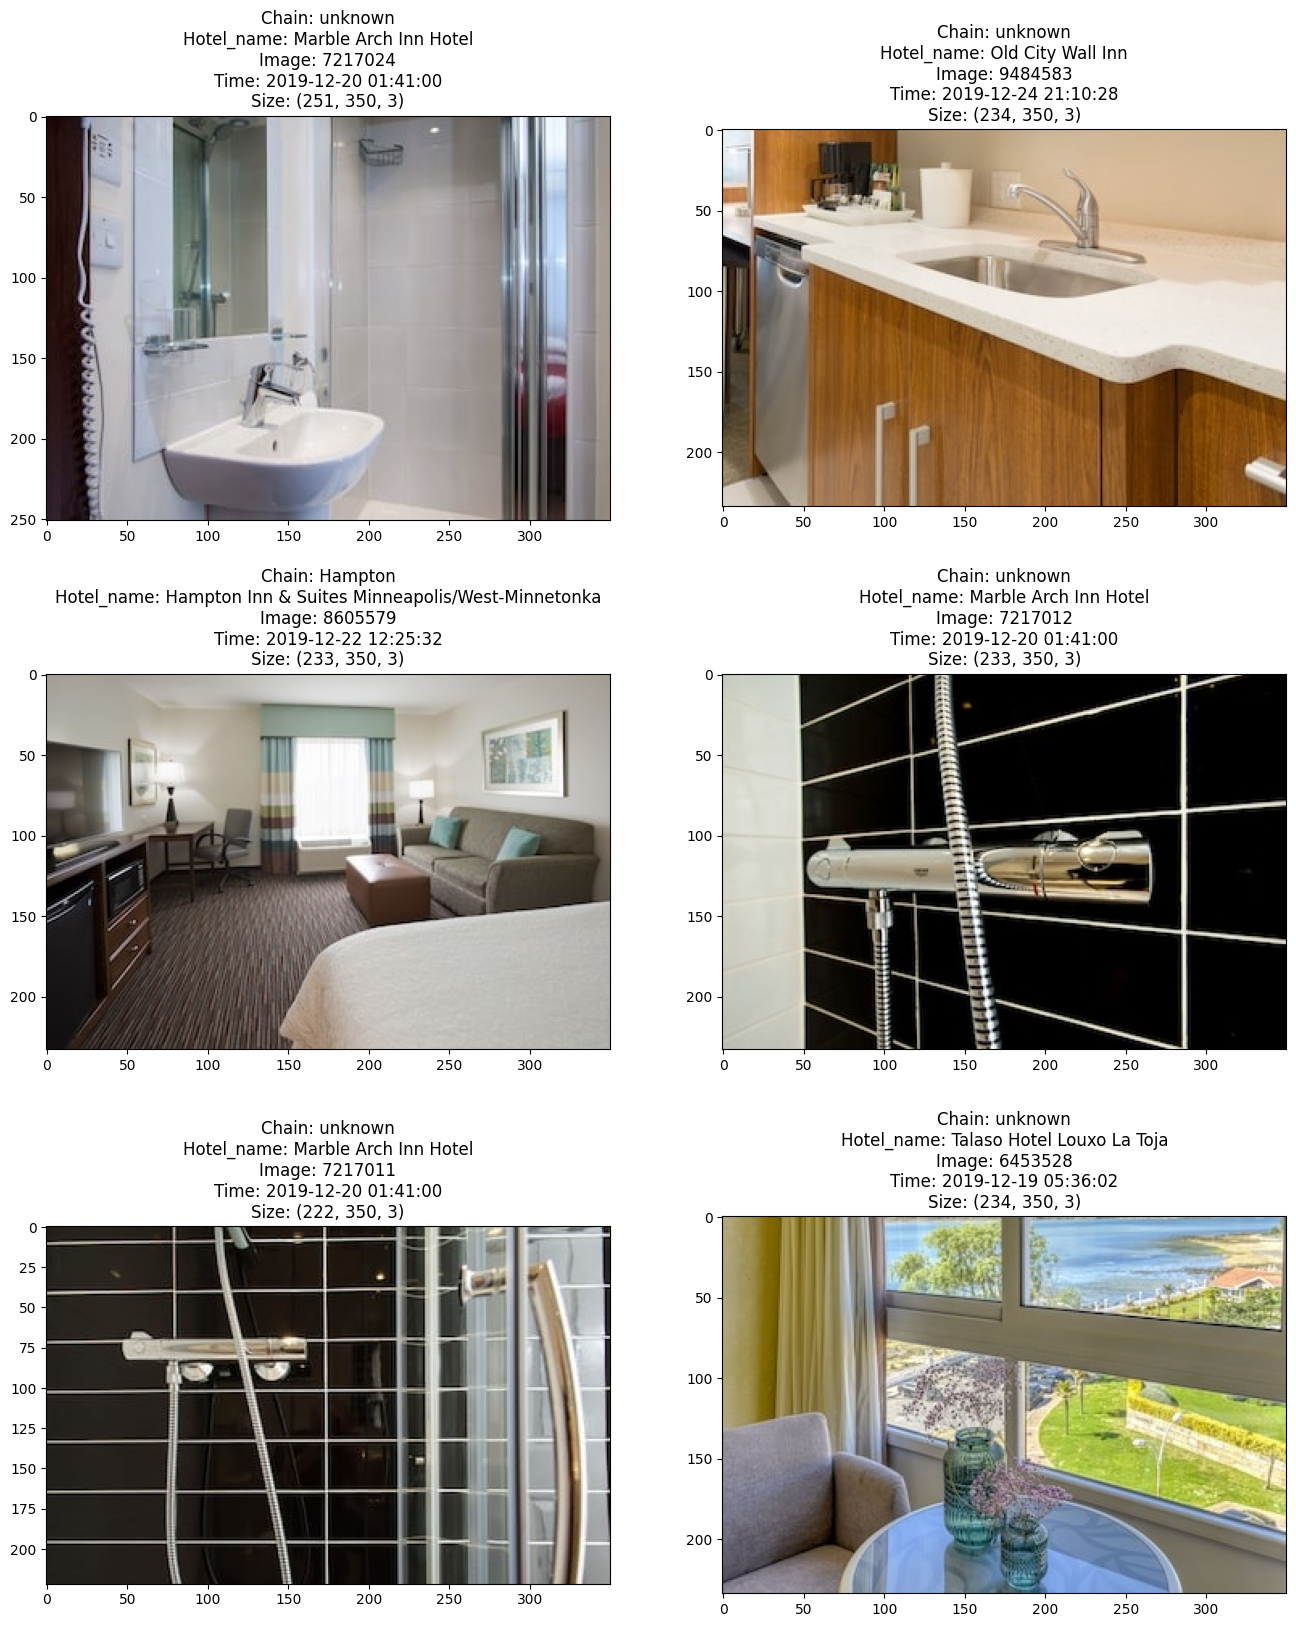

In [61]:
downloaded_df = sample_df[sample_df["downloaded"]].sample(6, random_state=42)

fig, axes = plt.subplots(3,2, figsize=(16,20))
axes = axes.ravel()

for i in range(6):
    sample = downloaded_df.iloc[i]
    img = cv2.imread(os.path.join(sample["image_folder"], sample["image_name"]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Chain: {sample.chain_name}\n" +
                     f"Hotel_name: {sample.hotel_name}\n"
                     f"Image: {sample.image_id}\n" +
                     f"Time: {sample.timestamp}\n" +
                     f"Size: {np.shape(img)}")

In [62]:
downloaded_df

,image_id,hotel_id,url,source,timestamp,hotel_name,chain_id,latitude,longitude,chain_name,downloaded,image_name,image_folder
145,7217024,36121,https://i.travelapi.com/hotels/2000000/1060000...,travel_website,2019-12-20 01:41:00,Marble Arch Inn Hotel,-1,51.51523,-0.16157,unknown,True,7217024.jpg,hotels-50k/images/train/-1/36121/travel_website
202,9484583,382433,https://i.travelapi.com/hotels/13000000/129900...,travel_website,2019-12-24 21:10:28,Old City Wall Inn,-1,18.78109,98.99487,unknown,True,9484583.jpg,hotels-50k/images/train/-1/382433/travel_website
223,8605579,89031,https://i.travelapi.com/hotels/9000000/8700000...,travel_website,2019-12-22 12:25:32,Hampton Inn & Suites Minneapolis/West-Minnetonka,91,44.97257,-93.41517,Hampton,True,8605579.jpg,hotels-50k/images/train/91/89031/travel_website
133,7217012,36121,https://i.travelapi.com/hotels/2000000/1060000...,travel_website,2019-12-20 01:41:00,Marble Arch Inn Hotel,-1,51.51523,-0.16157,unknown,True,7217012.jpg,hotels-50k/images/train/-1/36121/travel_website
132,7217011,36121,https://i.travelapi.com/hotels/2000000/1060000...,travel_website,2019-12-20 01:41:00,Marble Arch Inn Hotel,-1,51.51523,-0.16157,unknown,True,7217011.jpg,hotels-50k/images/train/-1/36121/travel_website
26,6453528,31078,https://i.travelapi.com/hotels/1000000/570000/...,travel_website,2019-12-19 05:36:02,Talaso Hotel Louxo La Toja,-1,42.48537,-8.84665,unknown,True,6453528.jpg,hotels-50k/images/train/-1/31078/travel_website


In [63]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

full_df = sample_df[sample_df["downloaded"]]

# Создайте список для хранения разрешений
image_resolutions = []

for i in range(len(full_df)):
    sample = full_df.iloc[i]
    img = cv2.imread(os.path.join(sample["image_folder"], sample["image_name"]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(img)
    image_resolutions.append(np.shape(img))


In [64]:
# Найдите минимальное и максимальное разрешение изображений
if image_resolutions:
    min_resolution = min(image_resolutions)
    max_resolution = max(image_resolutions)

    print(f"Минимальное разрешение: {min_resolution}")
    print(f"Максимальное разрешение: {max_resolution}")
else:
    print("Нет доступных изображений для анализа.")

Минимальное разрешение: (175, 350, 3)
Максимальное разрешение: (350, 239, 3)


In [65]:
downloaded_df = ((sample_df[sample_df['downloaded'] == True]).reset_index()).drop(columns=['index','image_id','hotel_id','source','timestamp','downloaded','chain_name','latitude','longitude'])
downloaded_df.head()

,url,hotel_name,chain_id,image_name,image_folder
0,https://i.travelapi.com/hotels/7000000/6140000...,Novum Style Hotel Berlin-Centrum,-1,8159825.jpg,hotels-50k/images/train/-1/21379/travel_website
1,https://i.travelapi.com/hotels/7000000/6140000...,Novum Style Hotel Berlin-Centrum,-1,8159826.jpg,hotels-50k/images/train/-1/21379/travel_website
2,https://i.travelapi.com/hotels/1000000/570000/...,Talaso Hotel Louxo La Toja,-1,6453515.jpg,hotels-50k/images/train/-1/31078/travel_website
3,https://i.travelapi.com/hotels/1000000/570000/...,Talaso Hotel Louxo La Toja,-1,6453516.jpg,hotels-50k/images/train/-1/31078/travel_website
4,https://i.travelapi.com/hotels/1000000/570000/...,Talaso Hotel Louxo La Toja,-1,6453517.jpg,hotels-50k/images/train/-1/31078/travel_website


# Дополнение тегами


In [66]:
from PIL import Image
import numpy as np
import requests
import random

import torch
from transformers import CLIPProcessor, CLIPModel
from io import BytesIO

In [67]:
hotel_tags = [
    'hotel lobby', 'hotel room', 'hotel reception',
    'hotel corridor', 'hotel restaurant', 'hotel pool',
    'hotel gym', 'hotel spa', 'hotel bar',
    'hotel lounge', 'hotel terrace', 'hotel garden',
    'hotel entrance', 'hotel parking', 'hotel elevator',
    'hotel stairs', 'hotel lobby seating', 'hotel check-in counter',
    'hotel check-out counter', 'hotel room service', 'hotel concierge',
    'hotel bellman', 'hotel luggage storage', 'hotel valet service',
    'hotel shuttle', 'hotel event space', 'hotel business center',
    'hotel conference room', 'hotel meeting room', 'hotel banquet hall',
    'hotel wedding venue', 'hotel spa treatment', 'hotel fitness center',
    'hotel swimming pool', 'hotel hot tub', 'hotel sauna',
    'hotel steam room', 'hotel massage', 'hotel bar lounge',
    'hotel restaurant dining', 'hotel room view', 'hotel balcony view'
]

hotel_items_tags = [
    'table', 'bed', 'chair',
    'desk', 'lamp', 'sofa',
    'mirror', 'wardrobe', 'couch',
    'curtains', 'carpet', 'shower',
    'bathtub', 'sink', 'toilet',
    'towel', 'robe', 'hairdryer',
    'pillow', 'blanket', 'sheets',
    'nightstand', 'hanger', 'television',
    'remote', 'cabinet', 'mini-bar',
    'coffee maker', 'fridge', 'microwave',
    'kettle', 'dishware',
    'iron', 'ironing board', 'safe',
    'alarm clock', 'telephone', 'telephone',
    'toiletries', 'shampoo', 'conditioner',
    'soap', 'luggage rack', 'dining table',
    'chandelier', 'painting', 'artwork',
    'smoke detector'
]

tags_input = hotel_tags + hotel_items_tags


In [68]:
len(tags_input)

90

Добавление тегов происходит по следующему алгоритму:
  1. Выделяем набор тегов из предметной области
  2. К тегам добавляем префикс "a photo of" исходя из указаний модели CLIPModel
  3. Приведем размеры картинки к 256х256.
  4. Далее выберем бокс заданных размеров по очереди от (32,32), (64,64), (128,128), (256,256)
  5. Пройдемся по всему изображению выбранными боксами по очереди.
  6. В каждом из боксов определим находящийся внутри объект подавая последовательно по 10 тегов для сравнения.
  7. Если в вероятность того, что заданный тег характеризует объект в боксе, выше 0.92, то добавляем тег в лист description.
  8. Перемешиваем исходную выборку тегов.
  9. Повторяем пункты 4 - 8 алгоритма десять раз
  10. Удаляем повторяющиеся теги из результирующего листа и убираем префикс "a photo of"
  11. Лист переводим в строку разделенную запятыми
  12. Возвращаем полученную строку

PS: Пункт 9 нужен для идеи "монте-карло". Мы набираем первые 10 тегов. Если на фотографии изображено, например, кресло, а  набор тегов [sofa, chair, bed], то вероятнее всего ни один из тегов присвоен не будет, так как объекты не сильно отличны друг от друга и вероятнсоть между ними распределится. Иными словами не будет объекта с вероятностью выше 0.95. Для этого перемешаем алгоритм и соберем новый набор тегов. Пусть получили набор [chair, phone, lamp]. В таком наборе кресло практически наверняка будет найдено.

In [69]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [71]:
def descriptions_append(image, box_size, tags, model, descriptions):
      for x in range(0, image.width, box_size[0]):
        for y in range(0, image.height, box_size[1]):
            box = (x, y, x + box_size[0], y + box_size[1])
            cropped_image = image.crop(box)

            inputs = processor(text=tags, images=cropped_image, return_tensors="pt", padding=True).to(DEVICE)

            with torch.no_grad():
                outputs = model(**inputs)
                logits_per_image = outputs.logits_per_image
                probs = logits_per_image.softmax(dim=1)

            max_prob, max_tag_idx = torch.max(probs, dim=1)
            max_tag = tags[max_tag_idx]
            if max_prob.item() > 0.95:
                descriptions.append(max_tag)
            return descriptions

def clean_description(descriptions):
    prefix = "a photo of "
    cleaned_descriptions = [" ".join([word for word in description.split() if word not in prefix]) for description in descriptions]
    return cleaned_descriptions


def add_prefix(tags):
    return ["a photo of " + tag for tag in tags]

def get_description(url, model, processor, tags):
    try:
      image = Image.open(BytesIO(requests.get(url).content))
    except:
      try:
        image = Image.open(url)
      except:
        raise FileExistsError

    image = image.resize((256, 256))

    descriptions = []

    worked_tags = add_prefix(tags)

    description_string = ''
    for i in range(10):
        random.shuffle(worked_tags)
        for index in range(0, len(worked_tags),10):
          current_tags = worked_tags[index:index+10]

          box_size = (32, 32)
          descriptions = descriptions_append(image, box_size, current_tags, model, descriptions)

          box_size = (64, 64)
          descriptions = descriptions_append(image, box_size, current_tags, model, descriptions)

          box_size = (128, 128)
          descriptions = descriptions_append(image, box_size, current_tags, model, descriptions)

          box_size = (256, 256)
          descriptions = descriptions_append(image, box_size, current_tags, model, descriptions)

    unique_cleaned_descriptions = clean_description(list(set(descriptions)))
    description_string = ', '.join(unique_cleaned_descriptions)

    return description_string

In [72]:
def add_description_to_data_row(row):
    url = row['url']
    description = get_description(url, model, processor, tags_input)
    return description


In [73]:
downloaded_df['image_description'] = downloaded_df.apply(add_description_to_data_row, axis=1)
tagged_df = downloaded_df

In [74]:
downloaded_df.tail(5)

,url,hotel_name,chain_id,image_name,image_folder,image_description
181,https://i.travelapi.com/hotels/1000000/20000/1...,Mercure Marseille Centre Vieux Port,46,6178472.jpg,hotels-50k/images/train/46/10174/travel_website,"hotel room, smoke detector, lamp, nightstand"
182,https://i.travelapi.com/hotels/1000000/20000/1...,Mercure Marseille Centre Vieux Port,46,6178473.jpg,hotels-50k/images/train/46/10174/travel_website,"hotel room, hotel massage"
183,https://i.travelapi.com/hotels/1000000/20000/1...,Mercure Marseille Centre Vieux Port,46,6178477.jpg,hotels-50k/images/train/46/10174/travel_website,"hotel room service, hotel room, hotel spa"
184,https://i.travelapi.com/hotels/1000000/20000/1...,Mercure Marseille Centre Vieux Port,46,6178481.jpg,hotels-50k/images/train/46/10174/travel_website,"hotel room, hotel meeting room"
185,https://i.travelapi.com/hotels/1000000/20000/1...,Mercure Marseille Centre Vieux Port,46,6178482.jpg,hotels-50k/images/train/46/10174/travel_website,"hotel spa treatment, hotel massage, hotel spa,..."


In [75]:
print("Всего доступно изображений: ", len(downloaded_df))
print("Количество комнат отеля без описания: ",len(downloaded_df[downloaded_df['image_description'] == ""]))
print("Количество комнат отеля с описанием: ",len(downloaded_df[downloaded_df['image_description'] != ""]))

Всего доступно изображений:  186
Количество комнат отеля без описания:  3
Количество комнат отеля с описанием:  183


In [76]:
photo = []

for i in range(len(downloaded_df)):
    sample = downloaded_df.iloc[i]
    img = cv2.imread(os.path.join(sample["image_folder"], sample["image_name"]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(img)
    photo.append((r, g, b))
    image_resolutions.append(np.shape(img))


def plot_image(index):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.dstack(photo[index]))
    plt.title(f"Image {index + 1}")
    plt.axis('off')
    plt.show()

interact(plot_image, index=widgets.IntSlider(min=0, max=len(photo)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=185), Output()), _dom_classes=('widget-inter…

<function __main__.plot_image(index)>

# Кластеризация датасета

In [77]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_tags(tags, num_clusters):
    """
    Кластеризует теги на указанное количество кластеров с использованием метода K-Means.

    Параметры:
    - tags: Список тегов для кластеризации.
    - num_clusters: Число кластеров, на которые нужно разделить теги.

    Возвращает:
    - labels: Метки кластеров для каждого тега.
    - cluster_centers: Центры кластеров.
    """

    tags_set = list(set(tags))
    tags_dict = {tag: i for i, tag in enumerate(tags_set)}
    tags_matrix = np.zeros((len(tags), len(tags_set)))
    for i, tag in enumerate(tags):
        tags_matrix[i, tags_dict[tag]] = 1

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)

    labels = kmeans.fit_predict(tags_matrix)

    cluster_centers = kmeans.cluster_centers_

    return labels, cluster_centers


In [78]:
num_clusters = len(downloaded_df['hotel_name'].drop_duplicates())  # Задайте желаемое количество кластеров
print("Количество кластеров:", num_clusters)
labels, cluster_centers = cluster_tags(tags_input, num_clusters)


Количество кластеров: 10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



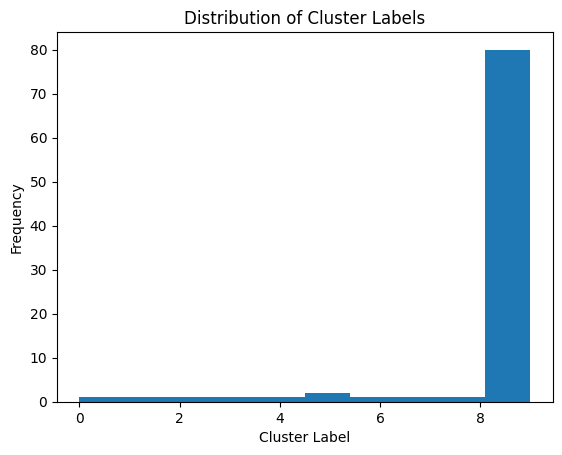

In [79]:
import matplotlib.pyplot as plt

"""Этот код строит гистограмму распределения меток кластеров и показывает,
сколько тегов принадлежит каждому кластеру. Если количество классов и
кластеров совпадает, то гистограмма должна показать равномерное
распределение по кластерам. """

plt.hist(labels, bins=num_clusters)
plt.xlabel("Cluster Label")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Labels")
plt.show()
